In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pymysql 
from scipy.optimize import curve_fit #拟合曲线
from scipy import interpolate  #插值


# 流程
一、原始js表清洗，原则：一阶差分为递减趋势<br>
二、向上平移方法：newSales=Sales+diff*b<br>
三、结合Googletrends，确认各个时间段（时间点）的系数u<br>
四、生成各个时间地点对应的newsales=F(t,rank)

# 一、平移核心函数 

In [58]:
def get_diff(js):
    diff=[]
    for cat in pd.value_counts(js['catId']).index:
        max_sales= max(js[js['catId']==cat]['sales'])
        if max_sales>1000:
            g=js[js['catId']==cat].sort_values('rank')
            x=list(g['rank'])
            y=list(g['sales'])
            dic=dict(zip(g['rank'],g['sales']))
            dic_1={k+1:y[k]-y[k+1] for k in range(0,len(y)-1) if y[k+1]-y[k]!=0}
            # 插值方式kind :["nearest", "zero", "slinear", "quadratic", "cubic"]
            f=interpolate.interp1d(list(dic_1.keys()),list(dic_1.values()),kind="nearest")
            x_new=[i for i in x if i<max(dic_1.keys())]
            y_1new=f(x_new)
            dic_diff={k:diff for k,diff in zip(x_new,y_1new)}
            for rank in x:
                if rank in dic_diff:
                    diff.append([cat,rank,dic_diff[rank]])
                else:
                    diff.append([cat,rank,0])
    return pd.DataFrame(diff,columns=['catId','rank','diff'])
def get_js2u(js,diff,u):
    '''
    js:columns['catId','rank','sales']
    u:向上平移,newjs/js=u  newSales=Sales+diff*b
    '''
    js=js.merge(diff,left_on=['catId','rank'],right_on=['catId','rank'])
    js2u=[]
    for cat in pd.value_counts(js['catId']).index:
        max_sales= max(js[js['catId']==cat]['sales'])
        if max_sales>1000:
            g=js[js['catId']==cat].sort_values('rank')
            #求系数为u，类目为cat的情况下，b值
            b=((u-1)*sum(g['sales']))/sum(g['diff'])
            for rank,sales,diff in zip(g['rank'],g['sales'],g['diff']):
                newjs=sales+b*diff
                js2u.append([cat,rank,newjs])
    return pd.DataFrame(js2u,columns=['catId','rank','newsales+{}'.format(round(u,2))])
if __name__=='__main__':
    js=pd.read_csv('sdb_sales_miku_06.csv')
    diff=get_diff(js)
    u=2  #newjs/js=u
    js2u=get_js2u(js,diff,u)
    js2u.head()

            


# 二、根据趋势定每日系数U，Google trend to u

In [69]:
trends=pd.read_excel('Google trends.xlsx')
trends.head(2)

,date,amazon,isPartial,ebay,diff,standard
0,2013-08-04,52,False,95,7,0.866667
1,2013-08-11,51,False,95,6,0.850000


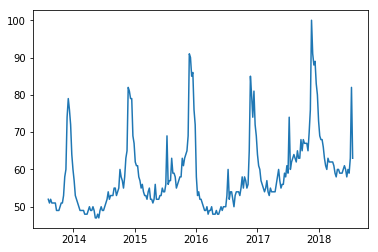

In [70]:

plt.plot(trends['date'],trends['amazon'])
# trends.head(60)

In [72]:
for date,u in zip(trends['date'],trends['standard']):
    if abs(u-1)>0.05:
        print(date,u)

2013-08-04 00:00:00 0.8666666666666667
2013-08-11 00:00:00 0.85
2013-08-18 00:00:00 0.8666666666666667
2013-08-25 00:00:00 0.85
2013-09-01 00:00:00 0.85
2013-09-08 00:00:00 0.85
2013-09-15 00:00:00 0.85
2013-09-22 00:00:00 0.8166666666666667
2013-09-29 00:00:00 0.8166666666666667
2013-10-06 00:00:00 0.8166666666666667
2013-10-13 00:00:00 0.8333333333333334
2013-10-20 00:00:00 0.85
2013-10-27 00:00:00 0.85
2013-11-03 00:00:00 0.8833333333333333
2013-11-24 00:00:00 1.2333333333333334
2013-12-01 00:00:00 1.3166666666666667
2013-12-08 00:00:00 1.2666666666666666
2013-12-15 00:00:00 1.2
2013-12-22 00:00:00 1.0666666666666667
2014-01-05 00:00:00 0.95
2014-01-12 00:00:00 0.8833333333333333
2014-01-19 00:00:00 0.8666666666666667
2014-01-26 00:00:00 0.85
2014-02-02 00:00:00 0.8333333333333334
2014-02-09 00:00:00 0.8166666666666667
2014-02-16 00:00:00 0.8166666666666667
2014-02-23 00:00:00 0.8166666666666667
2014-03-02 00:00:00 0.8166666666666667
2014-03-09 00:00:00 0.8
2014-03-16 00:00:00 0.8
2

# 三、各个月份，miku、js数据对比


In [61]:

dic_shop_time={
'Allrange':'2018-03-01',
 'Artarlei':'2018-02-01',
 'Evomotion':'2018-03-01',
 'FLYEGO':'2018-04-18',
 'Linkyo':'2018-06-28',
 'Lionet Paws':'2018-06-19',
 'Markbetter':'2018-03-01',
 'VuPoint':'2018-03-01',
 'sekey':'2018-01-01'}
t=pd.read_csv('asin_sales.csv',engine='python')
# t=raw_t.merge(asin_sale,left_on=['asin','date_time'],right_on=['asin','time'])
print(t.shape)
for shop in dic_shop_time:
    time=dic_shop_time[shop]
    t=t[~((t['shopName']==shop)&(t['date_time']<time))]
    print(shop,t.shape[0])
t['sales']=t['sales'].apply(lambda x:x*30)

(2871, 11)
Allrange 2593
Artarlei 2593
Evomotion 2593
FLYEGO 2593
Linkyo 2417
Lionet Paws 2410
Markbetter 2410
VuPoint 2410
sekey 1924


3


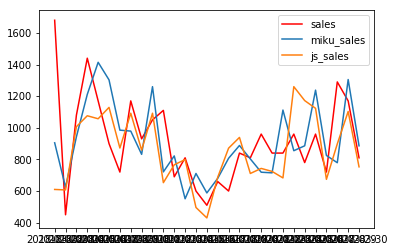

1927681.0 2253256.0


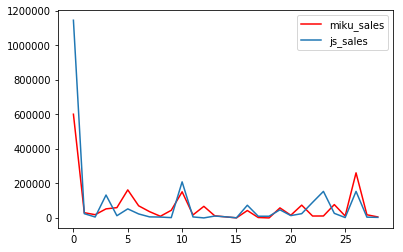

4


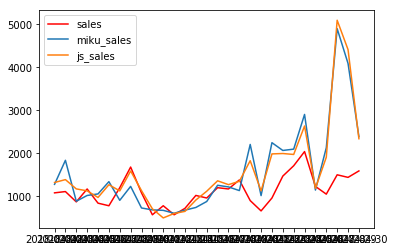

26668620.0 26568883.0


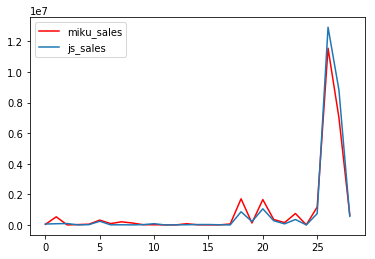

5


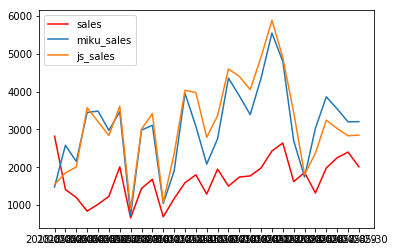

82457819.0 96921313.0


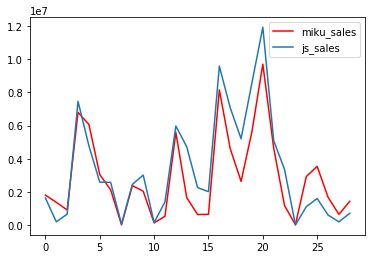

6


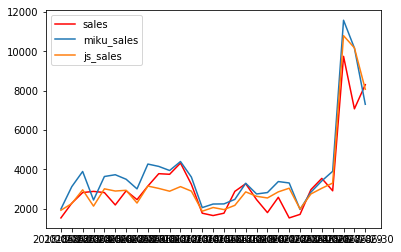

28253102.0 19298808.0


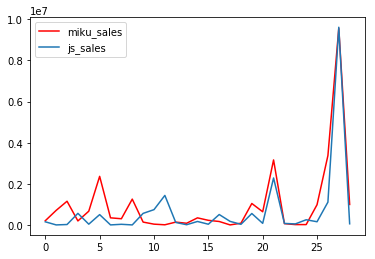

7


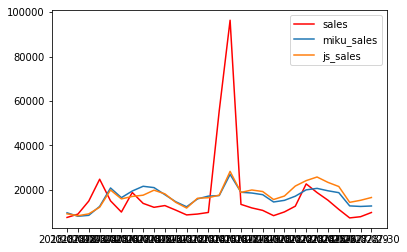

7180014295.0 7258496761.0


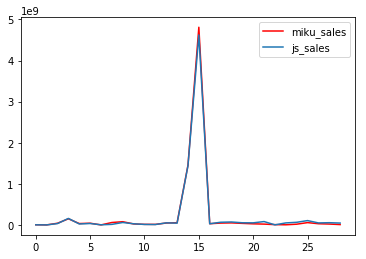

In [62]:
def compare_fig(g):
    plt.clf()
    plt.plot(g.index,g['sales'],'r',label=u'sales')
    plt.plot(g.index,g['miku_sales'],label=u'miku_sales')
    plt.plot(g.index,g['js_sales'],label=u'js_sales')
    plt.legend()
import time
for i in range(3,8):
    t1=t[(t['sales']>0)&(t['date_time']>'2018-0{}-01'.format(i))&(t['date_time']<'2018-0{}-31'.format(i))]
    g=t1.groupby(by=['date_time']).agg({'sales':sum,'miku_sales':sum,'js_sales':sum})
    compare_fig(g)
    print(i)
    plt.show()
    Y1=g['miku_sales']
    Y2=g['js_sales']
    X=g['sales']
    resid1=[(float(x)-float(y1))**2 for x,y1 in zip(X,Y1)]
    resid2=[(float(x)-float(y2))**2 for x,y2 in zip(X,Y2)]
    if sum(resid1)!=0:
        print(sum(resid1),sum(resid2))
        plt.clf()
        plt.plot(resid1,'r',label=u'miku_sales')
        plt.plot(resid2,label=u'js_sales')
        plt.legend()
        plt.show()
        time.sleep(2)

Allrange B01N7O6TXV miku: 13316193.0 js: 59084336.0


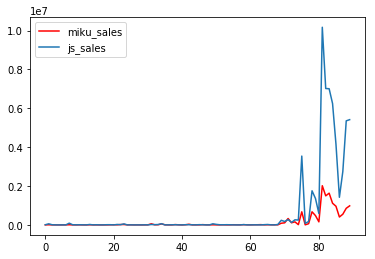

Allrange B01MZ5S8DJ miku: 2314967.0 js: 3901754.0


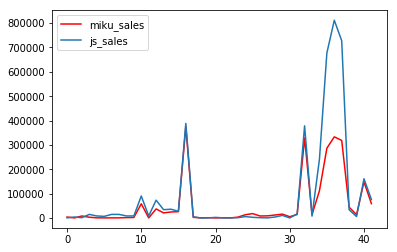

Allrange miku: 54206835.0 js: 225893505.0


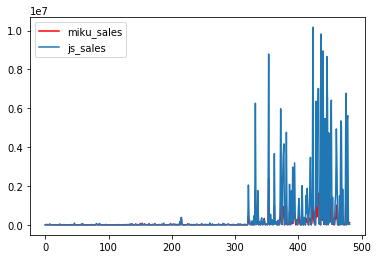

Artarlei miku: 16737281.0 js: 15099308.0


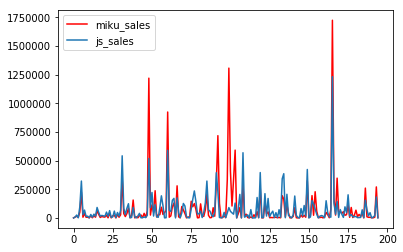

Evomotion miku: 29229877.0 js: 66616778.0


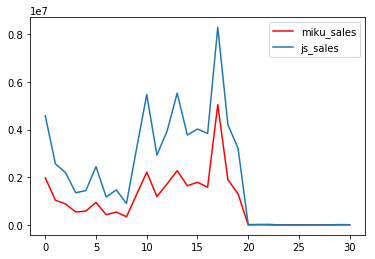

FLYEGO miku: 1871716.0 js: 1919878.0


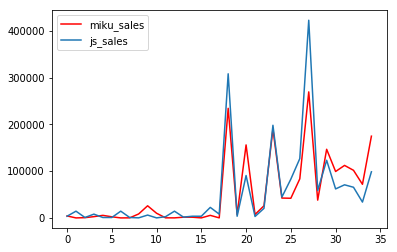

Linkyo miku: 6054874745.0 js: 6104917495.0


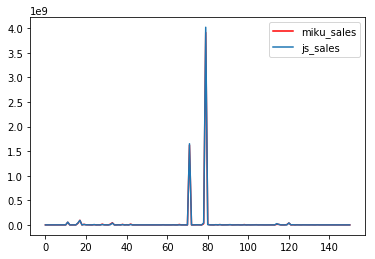

Lionet Paws B071CR79VL miku: 3711929.0 js: 2643245.0


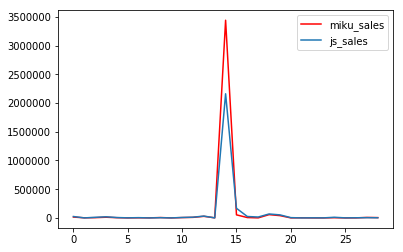

Lionet Paws miku: 3711929.0 js: 2643245.0


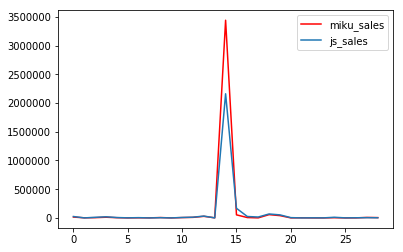

Markbetter miku: 86346.0 js: 30500.0


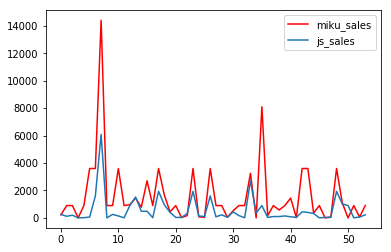

VuPoint miku: 100483783.0 js: 38817230.0


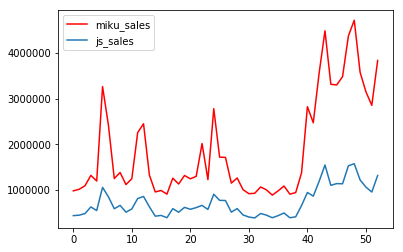

sekey miku: 9087188.0 js: 6263604.0


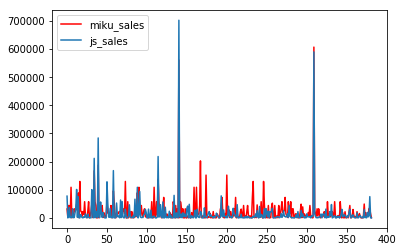

In [149]:
for shop in dic_shop_time:
    g0=t[(t['shopName']==shop)&(t['date_time']>dic_shop_time[shop])].groupby(by=['parentASIN','date_time']).agg({'sales':sum,'miku_sales':sum,'js_sales':sum})
    try:
        for p in set(t['parentASIN']):
            g0.reset_index(inplace=True)
            g=g0[g0['parentASIN']==p].sort_values('date_time')
            Y1=g['miku_sales']
            Y2=g['js_sales']
            X=g['sales']
            resid1=[(float(x)-float(y1))**2 for x,y1 in zip(X,Y1)]
            resid2=[(float(x)-float(y2))**2 for x,y2 in zip(X,Y2)]
            if sum(resid1)!=0:
                print(shop,p,'miku:',sum(resid1),'js:',sum(resid2))
                plt.clf()
                plt.plot(resid1,'r',label=u'miku_sales')
                plt.plot(resid2,label=u'js_sales')
                plt.legend()
                plt.show()
    except:
        g=g0.sort_values('date_time')
        Y1=g['miku_sales']
        Y2=g['js_sales']
        X=g['sales']
        resid1=[(float(x)-float(y1))**2 for x,y1 in zip(X,Y1)]
        resid2=[(float(x)-float(y2))**2 for x,y2 in zip(X,Y2)]
        if sum(resid1)!=0:
            print(shop,'miku:',sum(resid1),'js:',sum(resid2))
            plt.clf()
            plt.plot(resid1,'r',label=u'miku_sales')
            plt.plot(resid2,label=u'js_sales')
            plt.legend()
            plt.show()
        

In [194]:
def get_sqllist(sq):
        '''
        从sql中获取表格
        '''
        conn=pymysql.connect(host="us.uf61s4w7w057u60r4o.mysql.rds.sellermotor.com",user= 'sm_dba',
                             passwd= 'zr2P75BfUCRmlR4J',
                             db='sm_ad',
                             charset='utf8')
        cur=conn.cursor()
        cur.execute(sq)
        lists=cur.fetchall()
        cur.close()
        conn.close()
        return lists
#补全实际销售数据
filename='ad_rank_sales.xlsx'
raw_t=pd.read_excel(filename)
raw_t.columns


Asins=list(set(raw_t['asin']))
sq='''
select ASIN,QuantityOrdered,PurchaseDate from 
(select * from sdb_order_item where ASIN in {}) a 
LEFT JOIN
sdb_order b
on a.AmazonOrderId=b.AmazonOrderId
 ORDER BY QuantityOrdered desc;
'''.format(str(tuple(Asins)))
asin_sales=get_sqllist(sq)
asin_sales=pd.DataFrame(list(asin_sales),columns=['asin','sales','time'])
asin_sales['time']=asin_sales['time'].apply(lambda x:x[:10])
asin_sale=asin_sales.groupby(by=['asin','time']).agg({"sales":sum}).reset_index()
t=raw_t.merge(asin_sale,left_on=['asin','date_time'],right_on=['asin','time'])
# t.to_csv('asin_sales.csv')